# CAP 5636 2020 - Homework 3

In [1]:
import os
import pathlib
import random
import datetime
import functools

import numpy as np
# imports for visualization
import matplotlib.pyplot as plt
#import PIL 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from ImageDataset import DatasetCfg, create_dataset

import pickle

Setting up the directories for the data and temporary files. 

In [2]:
root_dir = pathlib.WindowsPath(".")
root_temp_dir = pathlib.Path(root_dir)
code_dir = pathlib.Path(root_dir)
temp_dir = pathlib.Path(root_temp_dir, "_Temporary")
temp_dir.mkdir(exist_ok = True, parents = True)

In [3]:
def create_model(cfg, modelname):
    if modelname == "simple-with-dropout":
        return create_standard_CNN(cfg, 0.2)
    if modelname == "simple-no-dropout":
        return create_standard_CNN(cfg, 0.0)
    if modelname == "inception":
        return create_inception(cfg)
    if modelname == "my-network-1":
        return create_my_network_1(cfg)
    if modelname == "my-network-2":
        return create_my_network_2(cfg)
    if modelname == "my-network-3":
        return create_my_network_3(cfg)
    raise RuntimeError(f"unknown model {modelname}")

    
def create_standard_CNN(cfg, dropout = 0.2, activation = 'relu'):
    """ Create a simple model with dropout"""
    model = Sequential([
        Conv2D(16, 3, padding='same', activation=activation, input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)),
        MaxPooling2D(),
        Dropout(dropout),
        Conv2D(32, 3, padding='same', activation=activation),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation=activation),
        MaxPooling2D(),
        Dropout(dropout),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(len(cfg.CLASS_NAMES)) 
    ])
    # 
    # in this case, it does not have a softmax output... because we are using cross-validation
    model.summary()
    return model

def create_inception(cfg):
    """ Create a model starting from the feature extraction layers of an Inception v3 network, 
    pre-trained on ImageNet. Train only the classifier on top of this network. 
    """
    # https://keras.io/api/applications/
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    #predictions = Dense(200, activation='softmax')(x)
    predictions = Dense(3)(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    model.summary()
    return model

In [4]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def create_my_network_1(cfg):
    """Replace this model with an alternative model"""
    # model = Sequential()
    # model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(cfg.IMG_HEIGHT, cfg.IMG_WIDTH ,3)));
    # model.add(Flatten())
    # model.add(Dense(10, activation='relu'))
    # model.add(Dense(len(cfg.CLASS_NAMES))) 

    # try out MobileNet, since it has been designed to perform decently on tasks that are data-starved, like this one (only 50 imgs per class)

    head = MobileNetV2(weights = "imagenet", alpha = 1.4, include_top = False)

    x = head.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)

    predictions = Dense(3)(x)

    model = Model(inputs = head.input, outputs = predictions)

    for layer in head.layers:
        layer.trainable = False

    model.summary()

    # POST-TRAINING NOTES:
    # MobileNet actually performs very well compared to Inceptionv3, especially early on in training. MobileNet's lightweight and simple inverted residual structure likely 
    # lends itself better to quicker convergence (training in < ~5 seconds, though on my GPU) and lighter resource dependence, compared to the huge Inception model making use of         # branched layer groups.
    
    # After implementing this, I realized that these networks were all pretrained on ImageNet anyway, so perhaps MobileNet may not have been the best choice for pure performance.
    # But it still learns very quickly, likely as a result of being configured for data-scarce, low-compute environments like mobile devices.
    # Since it is also pretrained, training of the few extra layers is very fast, and since it is lightweight, inference for evaluation is also very fast.

    return model

In [12]:
def create_my_network_2(cfg):
    """Replace this model with an alternative model"""

    # after an initial run of this version, I found that I was unable to train because tf didn't have access to enough of my GPU's memory, and likely could not store
    # the images in each batch and the weights during training without going out of memory (OOM). Thus, I added this snippet below to allow TF to use as much of my GPU's memory as       # possible. Though my GPU doesn't have as much memory as the TeslaV100's on Newton (it's only 8GB max), it should have been able to store a network this small

    # gpus = tf.config.list_physical_devices('GPU')
    
    # allow gpu memory usage growth
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config = config)

    # POST-TRAINING NOTES:
    # As expected, increasing the number of conv blocks did lead to an improvement in training and validation accuracy, but not by too much. Now, the model has just above a coinflip's probability of being correct, which still has room for improvement. 

    model = Sequential([
        Conv2D(32, 5, activation = 'relu', padding = 'same', input_shape = (cfg.IMG_HEIGHT, cfg.IMG_WIDTH, 3)), 
        MaxPooling2D(), 
        Conv2D(64, 5, activation = 'relu', padding = 'same'), 
        MaxPooling2D(), 
        Conv2D(128, 5, activation = 'relu', padding = 'same'), 
        MaxPooling2D(), 
        Conv2D(64, 5, activation = 'relu', padding = 'same'), 
        MaxPooling2D(), 
        Conv2D(32, 5, activation = 'relu', padding = 'same'), 
        MaxPooling2D(), 
        Flatten(), 
        Dense(10, activation = 'relu'), 
        Dense(len(cfg.CLASS_NAMES))
    ])

    model.summary()
    
    return model

In [43]:
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization, Activation

def create_my_network_3(cfg):
    """Replace this model with an alternative model"""

    # POST-TRAINING NOTES:
    # I'd used Spatial Dropout before as a way to improve feature learning performance in the early layers of convolution networks, because regular dropout does not do what dropout is supposed to do when applied to conv layers. Dropout is fine for neurons, but is ill-suited for feature maps because it only drops individual elements. Spatial dropout instead drops an entire 2d feature map, meaning that correlated pixels in a feature map are dropped TOGETHER, rather than disjointly and potentially randomly. If regular dropout was used, it can be thought of as having "holes" in the feature maps, where the holes are dropped out values and the remnants are related pixels that hadn't been dropped. And, given a feature with such "holes" in it (i.e. a feature map representing ear with some small sections randomly removed), a detector can still easily detect that feature using the remaining surroundings, defeating the point of dropout. Spatial dropout promotes independence for feature maps in the same way that regular dropout promotes independence and robustness of neurons.

    # however, after running the experiments, I found that spatial dropout (and even regular dropout applied after FC layers), proved less effective than the alternative option, which was to exclude. I believe this is caused by the extremely short training time. With only 12 epochs of training, a network should prioritize learning quickly. Dropout (and spatial dropout), however, effectively increase the time til convergence by a factor of the dropout rate (i.e. a dropout prob of 0.5 roughly doubles the time to convergence) which works against the low number of epochs. Had I had control over the number of training epochs, I believe using spatial (and regular) dropout would have provided better results and a more robust model with more training time. However, even with this disadvantage, this model still performs very well, averaging between 89-91% validation accuracy. Not quite as good as the fine-tuned models, but still getting close to the non-dropout CNNs, with better potential for generalization to more complex datasets.
    
    # allow gpu usage growth, same as above
    # config = tf.compat.v1.ConfigProto()
    # config.gpu_options.allow_growth = True
    # session = tf.compat.v1.Session(config = config)

    model = Sequential([
        Conv2D(16, 3, padding = 'same', input_shape = (cfg.IMG_HEIGHT, cfg.IMG_WIDTH, 3)),
        #Activation('relu'), 
        SpatialDropout2D(0.1), 
        MaxPooling2D(),
        #Dropout(0.2),
        Conv2D(32, 3, padding = 'same'), 
        #Activation('relu'), 
        SpatialDropout2D(0.1), 
        MaxPooling2D(),
        Conv2D(64, 3, padding = 'same'), 
        #Activation('relu'), 
        SpatialDropout2D(0.1), 
        MaxPooling2D(),
        #Dropout(0.2),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dropout(0.5), 
        Dense(len(cfg.CLASS_NAMES))
    ])

    model.summary()

    return model

In [44]:
class ExperimentSpecification:
    """Contains the various parameters of the experiment"""
    def __init__(self, datasetname = None, modelname = None):
        self.modelname = modelname
        self.datasetname = datasetname
        self.optimizer = "adam"
        self.target_epochs = 5
        
    def get_expname(self):
        """Returns a name generated from the parameters that can distinguish between 
        the experiments. The idea is that the different experiments will be put into 
        different directories"""
        return self.modelname + "-" + self.optimizer

In [45]:
class ExperimentResults:
    """ The class which will be saved and contains the experiment results """
    def __init__(self, exp_spec):
        self.exp_spec = exp_spec
        self.expname = exp_spec.get_expname()
        self.modelname = exp_spec.modelname
        self.epochs_trained = 0
        self.metrics = {'loss' : [], 'accuracy': [], 'val_loss': [], 'val_accuracy' : []}

In [46]:
def run_training_experiment(exp_spec):
    """ Runs a training experiment, returns the experimental results. The same function can be used 
    to return the experimental result"""
    # the directory of the current setup in temp
    temp_model_dir = pathlib.Path(temp_dir, exp_spec.get_expname())
    temp_model_dir.mkdir(exist_ok = True, parents = True)
    # paths to various files
    er_path = pathlib.Path(temp_model_dir, exp_spec.get_expname() + "_exprecord.pkl")
    checkpoint_path = pathlib.Path(temp_model_dir, "checkpoint.ckpt")
        
    exp_spec.dataset_dir = pathlib.WindowsPath(root_dir, exp_spec.datasetname)
    if not exp_spec.dataset_dir.exists():
        raise RuntimeError(f"Dataset directory does not exist {exp_spec.dataset_dir}")
    cfg = DatasetCfg(path_to_data = exp_spec.dataset_dir)
    
    # Load or create the experiment results. If we are done, just return that.
    if er_path.exists():
        with open(er_path, 'rb') as f:
            er = pickle.load(f)
        print(f"> > > Loaded the previous experiment results successfully from {er_path}")
        if er.epochs_trained >= exp_spec.target_epochs:
            print(f"> > > The experiment results have training epochs {er.epochs_trained},"
                  f" which is more than the one requested {exp_spec.target_epochs}, returning it without further training.")
            return er
    else:
        er = ExperimentResults(exp_spec)
    
    model = create_model(cfg, exp_spec.modelname)    
    # if there is something to load, load it back
    if er.epochs_trained > 0:
        model.load_weights(str(checkpoint_path))
    model.compile(optimizer=exp_spec.optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # callback for saving the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_path),
                                                     save_weights_only=True,
                                                     verbose=1)
    # create the training data
    train_data_gen, validation_data_gen = create_dataset(cfg)

    # proceeding in steps of only one epoch at a time, save the results etc.
    while er.epochs_trained < exp_spec.target_epochs:
        print(f"> > > Training {exp_spec.get_expname()} epoch {er.epochs_trained + 1} out of {exp_spec.target_epochs}")
        history = model.fit(
            train_data_gen,
            steps_per_epoch= cfg.training_count // cfg.BATCH_SIZE,
            epochs=1,
            validation_data=validation_data_gen,
            validation_steps= cfg.validation_count // cfg.BATCH_SIZE,
            callbacks=[cp_callback]
        )
        # copy the data
        er.epochs_trained = er.epochs_trained + 1
        for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            er.metrics[metric].append(history.history[metric][0])
        # update the accuracy etc here
        with open(er_path, 'wb') as f:
            # Pickle the experiment results
            pickle.dump(er, f)
    print(f"> > > Training of the requested number of epochs {exp_spec.target_epochs} done successfully.")
    return er

In [47]:
# Run all the specified experiments 
ds_name = "."
modelnames = ["simple-with-dropout", "simple-no-dropout", "inception", "my-network-1", "my-network-2", "my-network-3"]
ers = dict()

for modelname in modelnames:
    exp_spec = ExperimentSpecification(datasetname = ds_name, modelname = modelname)
    exp_spec.target_epochs = 12
    er = run_training_experiment(exp_spec)
    ers[modelname] = er

> > > Loaded the previous experiment results successfully from _Temporary\simple-with-dropout-adam\simple-with-dropout-adam_exprecord.pkl
> > > The experiment results have training epochs 12, which is more than the one requested 12, returning it without further training.
> > > Loaded the previous experiment results successfully from _Temporary\simple-no-dropout-adam\simple-no-dropout-adam_exprecord.pkl
> > > The experiment results have training epochs 12, which is more than the one requested 12, returning it without further training.
> > > Loaded the previous experiment results successfully from _Temporary\inception-adam\inception-adam_exprecord.pkl
> > > The experiment results have training epochs 12, which is more than the one requested 12, returning it without further training.
> > > Loaded the previous experiment results successfully from _Temporary\my-network-1-adam\my-network-1-adam_exprecord.pkl
> > > The experiment results have training epochs 12, which is more than the one req

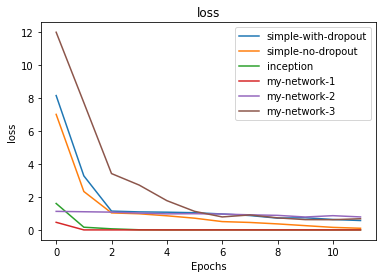

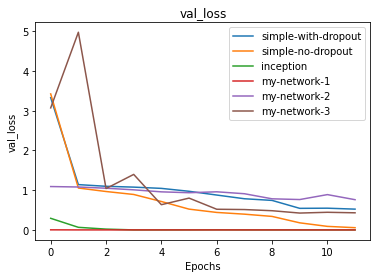

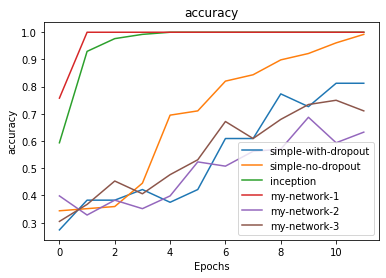

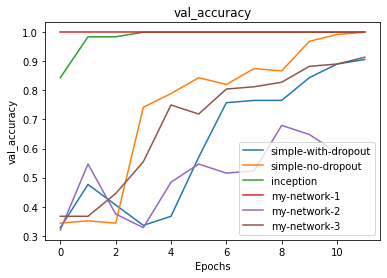

In [48]:
#plt.subplot(2,3,i+1)
def plot_experiment_results(er):
    #plt.title(er.exp_spec.get_expname())
    plt.plot(er.metrics['loss'])
    plt.plot(er.metrics['val_loss'])
    
def plot_metric(metric, ers):
    plt.figure()
    ax = plt.gca()
    ax.set_title(metric)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    for name in ers:
        plt.plot(ers[name].metrics[metric], label=name)
    ax.legend()
    
#  for name in ers:
#    plot_experiment_results(ers[name])

plot_metric('loss', ers)
plot_metric('val_loss', ers)
plot_metric('accuracy', ers)
plot_metric('val_accuracy', ers)